### 1. A* Search

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
import heapq
import random

class PuzzleState:
    def __init__(self, state, parent=None, action=None, cost=0):
        self.state = state
        self.parent = parent
        self.action = action
        self.cost = cost
        self.size = len(state)
        
    def __str__(self):
        return '\n'.join([' '.join(map(str, row)) for row in self.state])
        
    def find_blank(self):
        return next((i, j) for i in range(self.size) 
                   for j in range(self.size) if self.state[i][j] == 0)

def generate_random_state(n):
    while True:
        numbers = list(range(n*n))
        random.shuffle(numbers)
        state = [numbers[i:i+n] for i in range(0, n*n, n)]
        if is_solvable(state):
            return state

def get_successors(node):
    blank_i, blank_j = node.find_blank()
    moves = [(0, 1, 'R'), (1, 0, 'D'), (0, -1, 'L'), (-1, 0, 'U')]
    successors = []
    
    for di, dj, action in moves:
        new_i, new_j = blank_i + di, blank_j + dj
        if 0 <= new_i < node.size and 0 <= new_j < node.size:
            new_state = [row[:] for row in node.state]
            new_state[blank_i][blank_j], new_state[new_i][new_j] = \
                new_state[new_i][new_j], new_state[blank_i][blank_j]
            successors.append(PuzzleState(new_state, node, action, node.cost + 1))
    return successors

def get_inversions(state):
    flat = []
    for i in range(len(state)):
        for j in range(len(state)):
            if state[i][j] != 0:
                flat.append(state[i][j])
    
    inversions = 0
    for i in range(len(flat)):
        for j in range(i + 1, len(flat)):
            if flat[i] > flat[j]:
                inversions += 1
    return inversions

def is_solvable(state):
    n = len(state)
    inversions = get_inversions(state)
    
    blank_row = 0
    for i in range(n-1, -1, -1):
        for j in range(n):
            if state[i][j] == 0:
                blank_row = n - i
                break
    
    if n % 2 == 1:
        return inversions % 2 == 0
    else:
        if blank_row % 2 == 0:
            return inversions % 2 == 1
        else:
            return inversions % 2 == 0

# Heuristic functions
def misplaced_tiles(state, goal):
    count = 0
    for i in range(len(state)):
        for j in range(len(state)):
            if state[i][j] != 0 and state[i][j] != goal[i][j]:
                count += 1
    return count

def manhattan_distance(state, goal):
    n = len(state)
    distance = 0
    goal_pos = {}
    for i in range(n):
        for j in range(n):
            goal_pos[goal[i][j]] = (i, j)
    
    for i in range(n):
        for j in range(n):
            if state[i][j] != 0:
                gi, gj = goal_pos[state[i][j]]
                distance += abs(i - gi) + abs(j - gj)
    return distance

def linear_conflict(state, goal):
    n = len(state)
    conflict = manhattan_distance(state, goal)
    
    # Add linear conflict cost
    for i in range(n):
        for j in range(n):
            if state[i][j] == 0:
                continue
            goal_i, goal_j = None, None
            for x in range(n):
                for y in range(n):
                    if goal[x][y] == state[i][j]:
                        goal_i, goal_j = x, y
                        break
            
            # Check row and column conflicts
            if i == goal_i:
                for k in range(j + 1, n):
                    if state[i][k] != 0:
                        k_goal_i, k_goal_j = None, None
                        for x in range(n):
                            for y in range(n):
                                if goal[x][y] == state[i][k]:
                                    k_goal_i, k_goal_j = x, y
                                    break
                        if i == k_goal_i and goal_j > k_goal_j:
                            conflict += 2
    return conflict

def astar_solve(initial_state, goal_state, heuristic_func, timeout=60):
    if not is_solvable(initial_state):
        return None, 0, 0
        
    start_time = time.time()
    initial = PuzzleState(initial_state)
    frontier = [(0 + heuristic_func(initial_state, goal_state), 0, id(initial), initial)]
    heapq.heapify(frontier)
    visited = set()
    nodes_expanded = 0
    
    while frontier and (time.time() - start_time) < timeout:
        _, cost, _, current = heapq.heappop(frontier)
        state_tuple = tuple(map(tuple, current.state))
        
        if current.state == goal_state:
            path = []
            while current.parent:
                path.append(current.action)
                current = current.parent
            return path[::-1], time.time() - start_time, nodes_expanded
            
        if state_tuple not in visited:
            visited.add(state_tuple)
            nodes_expanded += 1
            for successor in get_successors(current):
                if tuple(map(tuple, successor.state)) not in visited:
                    h = heuristic_func(successor.state, goal_state)
                    f = successor.cost + h
                    heapq.heappush(frontier, (f, successor.cost, id(successor), successor))
    
    return None, time.time() - start_time, nodes_expanded

def run_experiment(n, algorithm, heuristic_func, heuristic_name):
    goal_state = [[i + 1 if i < n*n-1 else 0 for i in range(j*n, (j+1)*n)] 
                 for j in range(n)]
    
    results = []
    nodes_expanded_list = []
    timeouts = 0
    initial_states = [generate_random_state(n) for _ in range(10)]
    
    for i, init_state in enumerate(initial_states, 1):
        print(f"\nTrial {i}/10 for {n}x{n} puzzle using {heuristic_name}")
        print("Initial State:")
        print(PuzzleState(init_state))
        print("\nGoal State:")
        print(PuzzleState(goal_state))
        
        solution, solve_time, nodes = algorithm(init_state, goal_state, heuristic_func)
        
        if solution is not None and solve_time < 60:
            results.append(solve_time)
            nodes_expanded_list.append(nodes)
            print(f"Solved in {solve_time:.2f} seconds")
            print(f"Nodes expanded: {nodes}")
            print("Moves:", ' '.join(solution))
        else:
            timeouts += 1
            print("Timeout or no solution")
    
    if results:
        avg_time = sum(results) / len(results)
        avg_nodes = sum(nodes_expanded_list) / len(nodes_expanded_list)
        std_dev = np.std(results) if len(results) > 1 else 0
        print(f"\nResults for n={n}:")
        print(f"Average time: {avg_time:.2f} seconds")
        print(f"Average nodes expanded: {avg_nodes:.2f}")
        print(f"Standard deviation: {std_dev:.2f}")
        print(f"Successful solves: {len(results)}/10")
        return avg_time, avg_nodes, std_dev, len(results)
    return None, None, None, 0

def plot_results(n_values, algorithm_name, results_dict):
    # Plot time results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    
    for heuristic, data in results_dict.items():
        times = [t for t, _ in data if t is not None]
        if times:
            plt.plot(n_values[:len(times)], times, marker='o', label=heuristic)
    
    plt.xlabel('Grid Size (n)')
    plt.ylabel('Average Time (seconds)')
    plt.title(f'{algorithm_name} - Time Performance')
    plt.legend()
    plt.grid(True)
    
    # Plot nodes expanded
    plt.subplot(1, 2, 2)
    
    for heuristic, data in results_dict.items():
        nodes = [n for _, n in data if n is not None]
        if nodes:
            plt.plot(n_values[:len(nodes)], nodes, marker='o', label=heuristic)
    
    plt.xlabel('Grid Size (n)')
    plt.ylabel('Average Nodes Expanded')
    plt.title(f'{algorithm_name} - Nodes Expanded')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'{algorithm_name.lower().replace(" ", "_")}_results.png')
    plt.show()

def main():
    n_values = [2, 3]
    heuristics = {
        'Misplaced Tiles': misplaced_tiles,
        'Manhattan Distance': manhattan_distance,
        'Linear Conflict': linear_conflict
    }
    
    astar_results = {name: [] for name in heuristics}
    
    for n in n_values:
        print(f"\nTesting for n={n}")
        for heur_name, heur_func in heuristics.items():
            print(f"\nRunning A* with {heur_name}")
            avg_time, avg_nodes, _, _ = run_experiment(
                n, astar_solve, heur_func, f"A* - {heur_name}")
            if avg_time is not None:
                astar_results[heur_name].append((avg_time, avg_nodes))
    
    plot_results(n_values, "A Star Search", astar_results)

if __name__ == "__main__":
    main()


Testing for n=2

Running A* with Misplaced Tiles

Trial 1/10 for 2x2 puzzle using A* - Misplaced Tiles
Initial State:
2 0
1 3

Goal State:
1 2
3 0
Solved in 0.00 seconds
Nodes expanded: 3
Moves: L D R

Trial 2/10 for 2x2 puzzle using A* - Misplaced Tiles
Initial State:
0 1
3 2

Goal State:
1 2
3 0
Solved in 0.00 seconds
Nodes expanded: 2
Moves: R D

Trial 3/10 for 2x2 puzzle using A* - Misplaced Tiles
Initial State:
0 1
3 2

Goal State:
1 2
3 0
Solved in 0.00 seconds
Nodes expanded: 2
Moves: R D

Trial 4/10 for 2x2 puzzle using A* - Misplaced Tiles
Initial State:
2 3
0 1

Goal State:
1 2
3 0
Solved in 0.00 seconds
Nodes expanded: 7
Moves: R U L D R

Trial 5/10 for 2x2 puzzle using A* - Misplaced Tiles
Initial State:
2 3
0 1

Goal State:
1 2
3 0
Solved in 0.00 seconds
Nodes expanded: 7
Moves: R U L D R

Trial 6/10 for 2x2 puzzle using A* - Misplaced Tiles
Initial State:
2 0
1 3

Goal State:
1 2
3 0
Solved in 0.00 seconds
Nodes expanded: 3
Moves: L D R

Trial 7/10 for 2x2 puzzle using A

KeyboardInterrupt: 

### 2. Greedy Best-First Search


Testing for n=2

Running Greedy Best-First with Misplaced Tiles

Trial 1/10 for 2x2 puzzle using Greedy - Misplaced Tiles
Initial State:
0 2
1 3

Goal State:
1 2
3 0
Solved in 0.00 seconds
Nodes expanded: 2
Moves: D R

Trial 2/10 for 2x2 puzzle using Greedy - Misplaced Tiles
Initial State:
2 3
1 0

Goal State:
1 2
3 0
Solved in 0.00 seconds
Nodes expanded: 7
Moves: U L D R

Trial 3/10 for 2x2 puzzle using Greedy - Misplaced Tiles
Initial State:
3 1
0 2

Goal State:
1 2
3 0
Solved in 0.00 seconds
Nodes expanded: 3
Moves: U R D

Trial 4/10 for 2x2 puzzle using Greedy - Misplaced Tiles
Initial State:
2 3
1 0

Goal State:
1 2
3 0
Solved in 0.00 seconds
Nodes expanded: 8
Moves: L U R D L U R D

Trial 5/10 for 2x2 puzzle using Greedy - Misplaced Tiles
Initial State:
0 1
3 2

Goal State:
1 2
3 0
Solved in 0.00 seconds
Nodes expanded: 2
Moves: R D

Trial 6/10 for 2x2 puzzle using Greedy - Misplaced Tiles
Initial State:
3 1
2 0

Goal State:
1 2
3 0
Solved in 0.00 seconds
Nodes expanded: 5
Move

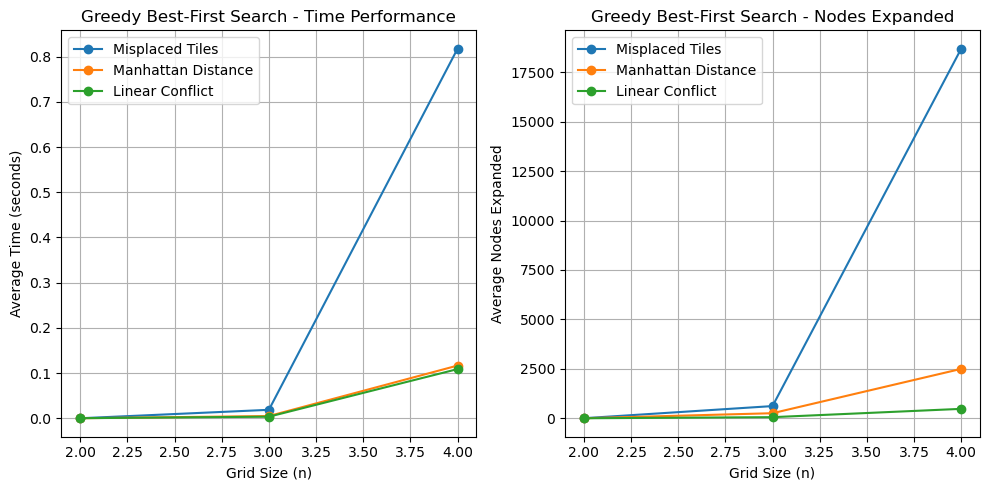

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
import heapq
import random

class PuzzleState:
    def __init__(self, state, parent=None, action=None, cost=0):
        self.state = state
        self.parent = parent
        self.action = action
        self.cost = cost
        self.size = len(state)
        
    def __str__(self):
        return '\n'.join([' '.join(map(str, row)) for row in self.state])
        
    def find_blank(self):
        return next((i, j) for i in range(self.size) 
                   for j in range(self.size) if self.state[i][j] == 0)

def generate_random_state(n):
    while True:
        numbers = list(range(n*n))
        random.shuffle(numbers)
        state = [numbers[i:i+n] for i in range(0, n*n, n)]
        if is_solvable(state):
            return state

def get_successors(node):
    blank_i, blank_j = node.find_blank()
    moves = [(0, 1, 'R'), (1, 0, 'D'), (0, -1, 'L'), (-1, 0, 'U')]
    successors = []
    
    for di, dj, action in moves:
        new_i, new_j = blank_i + di, blank_j + dj
        if 0 <= new_i < node.size and 0 <= new_j < node.size:
            new_state = [row[:] for row in node.state]
            new_state[blank_i][blank_j], new_state[new_i][new_j] = \
                new_state[new_i][new_j], new_state[blank_i][blank_j]
            successors.append(PuzzleState(new_state, node, action, node.cost + 1))
    return successors

def get_inversions(state):
    flat = []
    for i in range(len(state)):
        for j in range(len(state)):
            if state[i][j] != 0:
                flat.append(state[i][j])
    
    inversions = 0
    for i in range(len(flat)):
        for j in range(i + 1, len(flat)):
            if flat[i] > flat[j]:
                inversions += 1
    return inversions

def is_solvable(state):
    n = len(state)
    inversions = get_inversions(state)
    
    blank_row = 0
    for i in range(n-1, -1, -1):
        for j in range(n):
            if state[i][j] == 0:
                blank_row = n - i
                break
    
    if n % 2 == 1:
        return inversions % 2 == 0
    else:
        if blank_row % 2 == 0:
            return inversions % 2 == 1
        else:
            return inversions % 2 == 0

# Heuristic functions
def misplaced_tiles(state, goal):
    count = 0
    for i in range(len(state)):
        for j in range(len(state)):
            if state[i][j] != 0 and state[i][j] != goal[i][j]:
                count += 1
    return count

def manhattan_distance(state, goal):
    n = len(state)
    distance = 0
    goal_pos = {}
    for i in range(n):
        for j in range(n):
            goal_pos[goal[i][j]] = (i, j)
    
    for i in range(n):
        for j in range(n):
            if state[i][j] != 0:
                gi, gj = goal_pos[state[i][j]]
                distance += abs(i - gi) + abs(j - gj)
    return distance

def linear_conflict(state, goal):
    n = len(state)
    conflict = manhattan_distance(state, goal)
    
    # Add linear conflict cost
    for i in range(n):
        for j in range(n):
            if state[i][j] == 0:
                continue
            goal_i, goal_j = None, None
            for x in range(n):
                for y in range(n):
                    if goal[x][y] == state[i][j]:
                        goal_i, goal_j = x, y
                        break
            
            # Check row conflicts
            if i == goal_i:
                for k in range(j + 1, n):
                    if state[i][k] != 0:
                        k_goal_i, k_goal_j = None, None
                        for x in range(n):
                            for y in range(n):
                                if goal[x][y] == state[i][k]:
                                    k_goal_i, k_goal_j = x, y
                                    break
                        if i == k_goal_i and goal_j > k_goal_j:
                            conflict += 2
            
            # Check column conflicts
            if j == goal_j:
                for k in range(i + 1, n):
                    if state[k][j] != 0:
                        k_goal_i, k_goal_j = None, None
                        for x in range(n):
                            for y in range(n):
                                if goal[x][y] == state[k][j]:
                                    k_goal_i, k_goal_j = x, y
                                    break
                        if j == k_goal_j and goal_i > k_goal_i:
                            conflict += 2
    
    return conflict

def greedy_solve(initial_state, goal_state, heuristic_func, timeout=60):
    if not is_solvable(initial_state):
        return None, 0, 0
        
    start_time = time.time()
    initial = PuzzleState(initial_state)
    frontier = [(heuristic_func(initial_state, goal_state), id(initial), initial)]
    heapq.heapify(frontier)
    visited = set()
    nodes_expanded = 0
    
    while frontier and (time.time() - start_time) < timeout:
        _, _, current = heapq.heappop(frontier)
        state_tuple = tuple(map(tuple, current.state))
        
        if current.state == goal_state:
            path = []
            while current.parent:
                path.append(current.action)
                current = current.parent
            return path[::-1], time.time() - start_time, nodes_expanded
            
        if state_tuple not in visited:
            visited.add(state_tuple)
            nodes_expanded += 1
            for successor in get_successors(current):
                if tuple(map(tuple, successor.state)) not in visited:
                    h = heuristic_func(successor.state, goal_state)
                    heapq.heappush(frontier, (h, id(successor), successor))
    
    return None, time.time() - start_time, nodes_expanded

def run_experiment(n, algorithm, heuristic_func, heuristic_name):
    goal_state = [[i + 1 if i < n*n-1 else 0 for i in range(j*n, (j+1)*n)] 
                 for j in range(n)]
    
    results = []
    nodes_expanded_list = []
    timeouts = 0
    initial_states = [generate_random_state(n) for _ in range(10)]
    
    for i, init_state in enumerate(initial_states, 1):
        print(f"\nTrial {i}/10 for {n}x{n} puzzle using {heuristic_name}")
        print("Initial State:")
        print(PuzzleState(init_state))
        print("\nGoal State:")
        print(PuzzleState(goal_state))
        
        solution, solve_time, nodes = algorithm(init_state, goal_state, heuristic_func)
        
        if solution is not None and solve_time < 60:
            results.append(solve_time)
            nodes_expanded_list.append(nodes)
            print(f"Solved in {solve_time:.2f} seconds")
            print(f"Nodes expanded: {nodes}")
            print("Moves:", ' '.join(solution))
        else:
            timeouts += 1
            print("Timeout or no solution")
    
    if results:
        avg_time = sum(results) / len(results)
        avg_nodes = sum(nodes_expanded_list) / len(nodes_expanded_list)
        std_dev = np.std(results) if len(results) > 1 else 0
        print(f"\nResults for n={n}:")
        print(f"Average time: {avg_time:.2f} seconds")
        print(f"Average nodes expanded: {avg_nodes:.2f}")
        print(f"Standard deviation: {std_dev:.2f}")
        print(f"Successful solves: {len(results)}/10")
        return avg_time, avg_nodes, std_dev, len(results)
    return None, None, None, 0

def plot_results(n_values, algorithm_name, results_dict):
    # Plot time results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    
    for heuristic, data in results_dict.items():
        times = [t for t, _ in data if t is not None]
        if times:
            plt.plot(n_values[:len(times)], times, marker='o', label=heuristic)
    
    plt.xlabel('Grid Size (n)')
    plt.ylabel('Average Time (seconds)')
    plt.title(f'{algorithm_name} - Time Performance')
    plt.legend()
    plt.grid(True)
    
    # Plot nodes expanded
    plt.subplot(1, 2, 2)
    
    for heuristic, data in results_dict.items():
        nodes = [n for _, n in data if n is not None]
        if nodes:
            plt.plot(n_values[:len(nodes)], nodes, marker='o', label=heuristic)
    
    plt.xlabel('Grid Size (n)')
    plt.ylabel('Average Nodes Expanded')
    plt.title(f'{algorithm_name} - Nodes Expanded')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'{algorithm_name.lower().replace(" ", "_")}_results.png')
    plt.show()

def main():
    n_values = [2, 3, 4]
    heuristics = {
        'Misplaced Tiles': misplaced_tiles,
        'Manhattan Distance': manhattan_distance,
        'Linear Conflict': linear_conflict
    }
    
    greedy_results = {name: [] for name in heuristics}
    
    for n in n_values:
        print(f"\nTesting for n={n}")
        for heur_name, heur_func in heuristics.items():
            print(f"\nRunning Greedy Best-First with {heur_name}")
            avg_time, avg_nodes, _, _ = run_experiment(
                n, greedy_solve, heur_func, f"Greedy - {heur_name}")
            if avg_time is not None:
                greedy_results[heur_name].append((avg_time, avg_nodes))
    
    plot_results(n_values, "Greedy Best-First Search", greedy_results)

if __name__ == "__main__":
    main()